In [8]:
from pathlib import Path
import sys

import data_transformers as dt
from model_wrapper import model_wrapper as mw
import constants as co
from auxiliary import loggers, plotScatterWithIdeal, create_precision_recall_plot

import pandas as pd
import numpy as np
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env

from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE

from IPython.display import IFrame

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('display.max_columns', None)
random_seed = 42

%config Completer.use_jedi = False

In [9]:
l = loggers.get_logger(logger_name="logger")

In [10]:
def set_up_mlflow(experiment):
    server_ip = "10.210.200.190"
    os.environ['AWS_ACCESS_KEY_ID'] = 'mlflow'
    os.environ['AWS_SECRET_ACCESS_KEY'] = 'uSPmPqTZv4YQh8M7oMqq'
    os.environ['MLFLOW_S3_ENDPOINT_URL'] = f"http://{server_ip}:9000"
    mlflow.set_tracking_uri(f"http://{server_ip}:9002")
    mlflow.set_experiment(experiment)

In [11]:
l.info(os.environ['CONDA_DEFAULT_ENV'])

2022-06-21 05:19:35,247 - logger - INFO - rorgammaqsar
2022-06-21 05:19:35,247 - logger - INFO - rorgammaqsar


# Data load

In [12]:
smiles_column = "canonical_smiles_get_levels"
target_column = "IC50_nM"

max_level_activity = 13
train_data = pd.read_csv((co.DATA_DIR/"ror_gamma_homo_sapiens.csv").absolute().as_posix())
activity_columns = ["act_"+str(iii) for iii in range(max_level_activity)]
train_data["target_std"] = train_data[activity_columns].apply(lambda x: np.std(x), axis=1)
train_data["target_min"] = train_data[activity_columns].apply(lambda x: np.min(x), axis=1)
train_data["target_max"] = train_data[activity_columns].apply(lambda x: np.max(x), axis=1)
train_data["target_mean"] = train_data[activity_columns].apply(lambda x: np.mean(x), axis=1)
train_data["target_median"] = train_data[activity_columns].apply(lambda x: np.median(x[~np.isnan(x)]), axis=1)
train_data[target_column] = train_data["target_median"]
# here we exclude the molecules for which the std of the available measurements is significant 
target_std_threshold = 100
train_data = train_data[train_data["target_std"] < target_std_threshold]
train_data

,molregno,standard_value_get_mean,standard_units_get_levels,standard_type_get_levels,chembl_id_compound_get_levels,canonical_smiles_get_levels,act_0,act_1,act_2,act_3,act_4,act_5,act_6,act_7,act_8,act_9,act_10,act_11,act_12,target_std,target_min,target_max,target_mean,target_median,IC50_nM
0,2208,199.53,nM,IC50,CHEMBL38,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)C(C)(C)CCC1,199.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,199.53,199.53,199.53,199.53,199.53
1,40459,31900.00,nM,IC50,CHEMBL28721,O=C(O)C(S)C(S)C(=O)O,31900.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,31900.00,31900.00,31900.00,31900.00,31900.00
3,155592,10000.00,nM,IC50,CHEMBL418971,CC(C)(c1ccc(O)cc1)c1ccc(O)cc1,10000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10000.00,10000.00,10000.00,10000.00,10000.00
5,242555,80000.00,nM,IC50,CHEMBL358290,NS(=O)(=O)c1ccc(N/C(S)=N\CCc2ccccc2)cc1,80000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,80000.00,80000.00,80000.00,80000.00,80000.00
6,342149,10000.00,nM,IC50,CHEMBL382792,O=S(=O)(Nc1ccc(C(O)(C(F)(F)F)C(F)(F)F)cc1)c1cc...,10000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10000.00,10000.00,10000.00,10000.00,10000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2214,2459056,193.60,nM,IC50,CHEMBL4588625,C[C@H]1CN(C2CCc3ccc(NC(=O)c4cccc(C#N)c4)cc32)C...,193.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,193.60,193.60,193.60,193.60,193.60
2215,2459160,75.00,nM,IC50,CHEMBL4588729,O=C(O)c1ccc(-n2cc(C(=O)c3c(Cl)cccc3Cl)c3ccccc3...,75.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,75.00,75.00,75.00,75.00,75.00
2217,2462878,27.00,nM,IC50,CHEMBL4592447,Cc1cccc(Cl)c1C(=O)c1cn(-c2ccc(C(=O)O)cc2F)c2nc...,27.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,27.00,27.00,27.00,27.00,27.00
2218,2463217,357.70,nM,IC50,CHEMBL4592786,N#Cc1cccc(NC(=O)Nc2ccc3c(c2)C(N2CC4CCC(C2)N4C(...,357.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,357.70,357.70,357.70,357.70,357.70


# Data

In [13]:
smiles_codes = train_data["canonical_smiles_get_levels"].copy()
target = train_data["IC50_nM"].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_file = "pipeline_configuration_tsne_PCA_20.json"
pipeline_configuration = dt.read_in_pipeline(pipeline_file=pipeline_file, pipeline_directory=co.PIPELINE_DIR)
pipeline = dt.create_pipeline(pipeline_configuration=pipeline_configuration["feature_transform"])

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

pipeline.fit(X=smiles_codes, y=None)
X_train = dt.create_molecular_features(pipeline=pipeline, smiles_codes=smiles_codes)
X_train = dt.process_molecular_features(pipeline=pipeline, X=X_train)

2022-06-21 05:19:42,341 - logger - INFO - PCA constructor...
2022-06-21 05:19:42,341 - logger - INFO - PCA constructor...
2022-06-21 05:19:42,343 - logger - INFO - CreateFPS fit...
2022-06-21 05:19:42,343 - logger - INFO - CreateFPS fit...
2022-06-21 05:19:42,344 - logger - INFO - CreateFPS transform...
2022-06-21 05:19:42,344 - logger - INFO - CreateFPS transform...
2022-06-21 05:19:43,440 - logger - INFO - Scaler fit...
2022-06-21 05:19:43,440 - logger - INFO - Scaler fit...
2022-06-21 05:19:43,552 - logger - INFO - CreateFPS fit...
2022-06-21 05:19:43,552 - logger - INFO - CreateFPS fit...
2022-06-21 05:19:43,553 - logger - INFO - CreateFPS transform...
2022-06-21 05:19:43,553 - logger - INFO - CreateFPS transform...
2022-06-21 05:19:44,634 - logger - INFO - PCA transform...
2022-06-21 05:19:44,634 - logger - INFO - PCA transform...


array([[<AxesSubplot:title={'center':'pca_0'}>,
        <AxesSubplot:title={'center':'pca_1'}>],
       [<AxesSubplot:title={'center':'pca_2'}>,
        <AxesSubplot:title={'center':'pca_3'}>]], dtype=object)

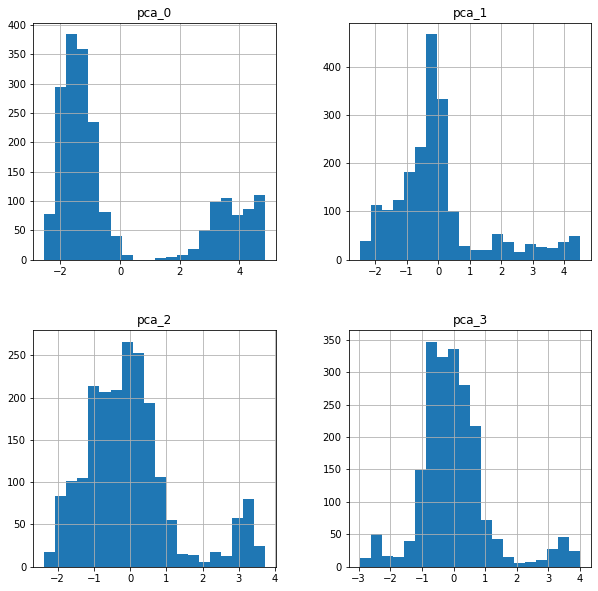

In [14]:
pca_columns = pipeline["PCA"].PCA_feature_names
X_train[pca_columns[:4]].hist(bins=20, grid=True, figsize=(10, 10))

In [15]:
ve_sum = np.sum(pipeline["PCA"].PCA_model.explained_variance_ratio_)
l.info("Variance explained: "+str(ve_sum))

2022-06-21 05:19:53,907 - logger - INFO - Variance explained: 0.5293176252172085
2022-06-21 05:19:53,907 - logger - INFO - Variance explained: 0.5293176252172085


In [16]:
tsne = TSNE(n_components=2)
tsne_embedding = tsne.fit_transform(X_train)
tsne_embedding = pd.DataFrame(tsne_embedding, index=X_train.index)
tsne_embedding = pd.concat([tsne_embedding, y_train], axis=1)
tsne_embedding.columns = ["tsne_1", "tsne_2", "active"]

/home/rafalb/miniconda3/envs/rorgammaqsar/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/rafalb/miniconda3/envs/rorgammaqsar/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [17]:
tsne_embedding

,tsne_1,tsne_2,active
0,-6.575310,5.724717,True
1,-5.864764,7.123019,False
3,-7.108779,7.889089,False
5,-6.819077,15.529951,False
6,-30.209444,6.655107,False
...,...,...,...
2214,-30.555685,29.479317,True
2215,62.816048,-8.852067,True
2217,60.942657,-7.596187,True
2218,-29.888960,30.100756,True


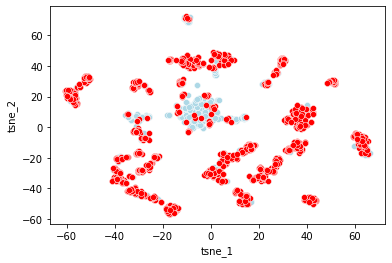

In [23]:
ax = sns.scatterplot(data=tsne_embedding.query("active == 0"), x="tsne_1", y="tsne_2", color='lightblue')#, size=(10, 10))
ax = sns.scatterplot(data=tsne_embedding.query("active == 1"), x="tsne_1", y="tsne_2", color='red')#, size=(10, 10))

#ax.set_figwidth(12)
#ax.set_figheight(10)

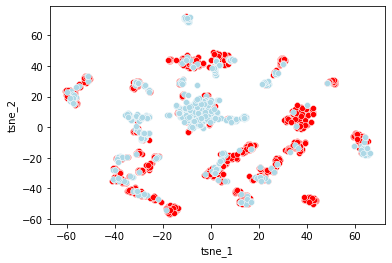

In [24]:
ax = sns.scatterplot(data=tsne_embedding.query("active == 1"), x="tsne_1", y="tsne_2", color='red')#, size=(10, 10))
ax = sns.scatterplot(data=tsne_embedding.query("active == 0"), x="tsne_1", y="tsne_2", color='lightblue')#, size=(10, 10))


In [14]:
smiles_codes = train_data["canonical_smiles_get_levels"].copy()
target = train_data["IC50_nM"].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_file = "pipeline_configuration_tsne_PCA_50.json"
pipeline_configuration = dt.read_in_pipeline(pipeline_file=pipeline_file, pipeline_directory=co.PIPELINE_DIR)
pipeline = dt.create_pipeline(pipeline_configuration=pipeline_configuration["feature_transform"])

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

pipeline.fit(X=smiles_codes, y=None)
X_train = dt.create_molecular_features(pipeline=pipeline, smiles_codes=smiles_codes)
X_train = dt.process_molecular_features(pipeline=pipeline, X=X_train)

2022-06-10 06:02:34,704 - logger - INFO - PCA constructor...
2022-06-10 06:02:34,704 - logger - INFO - PCA constructor...
2022-06-10 06:02:34,707 - logger - INFO - CreateFPS fit...
2022-06-10 06:02:34,707 - logger - INFO - CreateFPS fit...
2022-06-10 06:02:34,708 - logger - INFO - CreateFPS transform...
2022-06-10 06:02:34,708 - logger - INFO - CreateFPS transform...
2022-06-10 06:02:35,832 - logger - INFO - Scaler fit...
2022-06-10 06:02:35,832 - logger - INFO - Scaler fit...
2022-06-10 06:02:35,960 - logger - INFO - CreateFPS transform...
2022-06-10 06:02:35,960 - logger - INFO - CreateFPS transform...
2022-06-10 06:02:37,094 - logger - INFO - PCA transform...
2022-06-10 06:02:37,094 - logger - INFO - PCA transform...


In [15]:
ve_sum = np.sum(pipeline["PCA"].PCA_model.explained_variance_ratio_)
l.info("Variance explained: "+str(ve_sum))

2022-06-10 06:02:49,933 - logger - INFO - Variance explained: 0.6871564432339895
2022-06-10 06:02:49,933 - logger - INFO - Variance explained: 0.6871564432339895


In [16]:
tsne = TSNE(n_components=2)
tsne_embedding = tsne.fit_transform(X_train)
tsne_embedding = pd.DataFrame(tsne_embedding, index=X_train.index)
tsne_embedding = pd.concat([tsne_embedding, y_train], axis=1)
tsne_embedding.columns = ["tsne_1", "tsne_2", "active"]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


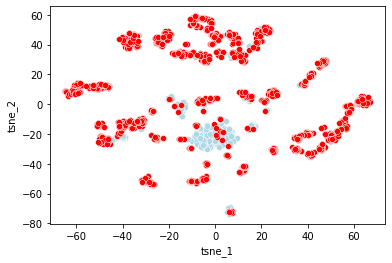

In [17]:
ax = sns.scatterplot(data=tsne_embedding.query("active == 0"), x="tsne_1", y="tsne_2", color='lightblue')
ax = sns.scatterplot(data=tsne_embedding.query("active == 1"), x="tsne_1", y="tsne_2", color='red')

In [19]:
smiles_codes = train_data["canonical_smiles_get_levels"].copy()
target = train_data["IC50_nM"].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_file = "pipeline_configuration_tsne_PCA_100.json"
pipeline_configuration = dt.read_in_pipeline(pipeline_file=pipeline_file, pipeline_directory=co.PIPELINE_DIR)
pipeline = dt.create_pipeline(pipeline_configuration=pipeline_configuration["feature_transform"])

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

pipeline.fit(X=smiles_codes, y=None)
X_train = dt.create_molecular_features(pipeline=pipeline, smiles_codes=smiles_codes)
X_train = dt.process_molecular_features(pipeline=pipeline, X=X_train)

2022-06-10 06:04:02,950 - logger - INFO - PCA constructor...
2022-06-10 06:04:02,950 - logger - INFO - PCA constructor...
2022-06-10 06:04:02,952 - logger - INFO - CreateFPS fit...
2022-06-10 06:04:02,952 - logger - INFO - CreateFPS fit...
2022-06-10 06:04:02,953 - logger - INFO - CreateFPS transform...
2022-06-10 06:04:02,953 - logger - INFO - CreateFPS transform...
2022-06-10 06:04:04,060 - logger - INFO - Scaler fit...
2022-06-10 06:04:04,060 - logger - INFO - Scaler fit...
2022-06-10 06:04:04,379 - logger - INFO - CreateFPS transform...
2022-06-10 06:04:04,379 - logger - INFO - CreateFPS transform...
2022-06-10 06:04:05,500 - logger - INFO - PCA transform...
2022-06-10 06:04:05,500 - logger - INFO - PCA transform...


In [20]:
ve_sum = np.sum(pipeline["PCA"].PCA_model.explained_variance_ratio_)
l.info("Variance explained: "+str(ve_sum))

2022-06-10 06:04:13,783 - logger - INFO - Variance explained: 0.7976720907346284
2022-06-10 06:04:13,783 - logger - INFO - Variance explained: 0.7976720907346284


In [21]:
tsne = TSNE(n_components=2)
tsne_embedding = tsne.fit_transform(X_train)
tsne_embedding = pd.DataFrame(tsne_embedding, index=X_train.index)
tsne_embedding = pd.concat([tsne_embedding, y_train], axis=1)
tsne_embedding.columns = ["tsne_1", "tsne_2", "active"]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


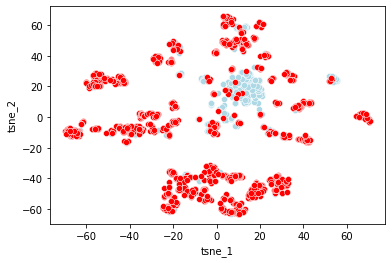

In [22]:
ax = sns.scatterplot(data=tsne_embedding.query("active == 0"), x="tsne_1", y="tsne_2", color='lightblue')
ax = sns.scatterplot(data=tsne_embedding.query("active == 1"), x="tsne_1", y="tsne_2", color='red')

In [23]:
smiles_codes = train_data["canonical_smiles_get_levels"].copy()
target = train_data["IC50_nM"].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_file = "pipeline_configuration_tsne_PCA_250.json"
pipeline_configuration = dt.read_in_pipeline(pipeline_file=pipeline_file, pipeline_directory=co.PIPELINE_DIR)
pipeline = dt.create_pipeline(pipeline_configuration=pipeline_configuration["feature_transform"])

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

pipeline.fit(X=smiles_codes, y=None)
X_train = dt.create_molecular_features(pipeline=pipeline, smiles_codes=smiles_codes)
X_train = dt.process_molecular_features(pipeline=pipeline, X=X_train)

2022-06-10 06:05:57,966 - logger - INFO - PCA constructor...
2022-06-10 06:05:57,966 - logger - INFO - PCA constructor...
2022-06-10 06:05:57,968 - logger - INFO - CreateFPS fit...
2022-06-10 06:05:57,968 - logger - INFO - CreateFPS fit...
2022-06-10 06:05:57,968 - logger - INFO - CreateFPS transform...
2022-06-10 06:05:57,968 - logger - INFO - CreateFPS transform...
2022-06-10 06:05:59,066 - logger - INFO - Scaler fit...
2022-06-10 06:05:59,066 - logger - INFO - Scaler fit...
2022-06-10 06:05:59,477 - logger - INFO - CreateFPS transform...
2022-06-10 06:05:59,477 - logger - INFO - CreateFPS transform...
2022-06-10 06:06:00,594 - logger - INFO - PCA transform...
2022-06-10 06:06:00,594 - logger - INFO - PCA transform...


In [24]:
ve_sum = np.sum(pipeline["PCA"].PCA_model.explained_variance_ratio_)
l.info("Variance explained: "+str(ve_sum))

2022-06-10 06:06:04,194 - logger - INFO - Variance explained: 0.9156650312909285
2022-06-10 06:06:04,194 - logger - INFO - Variance explained: 0.9156650312909285


In [25]:
tsne = TSNE(n_components=2)
tsne_embedding = tsne.fit_transform(X_train)
tsne_embedding = pd.DataFrame(tsne_embedding, index=X_train.index)
tsne_embedding = pd.concat([tsne_embedding, y_train], axis=1)
tsne_embedding.columns = ["tsne_1", "tsne_2", "active"]

/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/rafalb/miniconda3/envs/rorgammaqsar2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


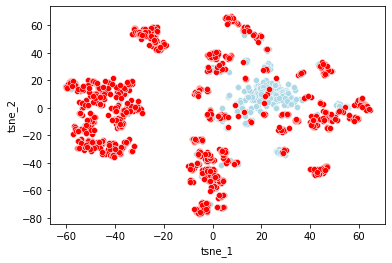

In [26]:
ax = sns.scatterplot(data=tsne_embedding.query("active == 0"), x="tsne_1", y="tsne_2", color='lightblue')
ax = sns.scatterplot(data=tsne_embedding.query("active == 1"), x="tsne_1", y="tsne_2", color='red')

# Analysis of the performance of certain mode

In [5]:
m_c = mw.M_XGBoost(prediction_type=mw.Prediction_Type.CLASSIFICATION, pipeline_configuration=None)
model_file = "test_model_20220620_xgboost_classifier.model"
path = Path(co.MODEL_DIR/model_file).absolute().as_posix()
m_c.Load(path)

In [6]:
smiles_codes_val = m_c.Data["smiles_codes_val"]
smiles_codes_train = m_c.Data["smiles_codes_train"]
m_c.Pipeline.fit(X=smiles_codes_train, y=None)
X_val = dt.create_molecular_features(pipeline=m_c.Pipeline, smiles_codes=smiles_codes_val)
X_val = dt.process_molecular_features(pipeline=m_c.Pipeline, X=X_val)
y_train_val_pred = m_c.Predict(X_val)
y_train_val = m_c.Data["targets_val"]
ConfusionMatrixDisplay.from_estimator(m_c.Model, X_val, y_train_val)

2022-06-21 04:41:47,453 - logger - INFO - CreateFPS fit...
2022-06-21 04:41:47,454 - logger - INFO - CreateFPS fit...
2022-06-21 04:41:47,455 - logger - INFO - CreateFPS transform...
100%|██████████| 208/208 [00:05<00:00, 38.69it/s]


ValueError: Feature shape mismatch, expected: 1035, got 1080